# DETR for Object Detection
This Jupyter notebook is designed to implement the DETR (DEtection TRansformer) model for object detection. Here's a step-by-step overview of what the notebook does:

1. **Introduction to DETR**: The notebook starts with a brief explanation of the DETR model, its components, and its advantages and disadvantages.

2. **Import Libraries**: It imports necessary libraries such as PyTorch, Transformers, PyTorch Lightning, and others.

3. **Prepare the Dataset**: The notebook reads a CSV file containing image annotations and splits it into training and validation datasets.

4. **Convert the Dataset to COCO Format**: The notebook converts the CSV file to the COCO (Common Objects in Context) format, which is a standard format for image annotation in the machine learning community.

5. **Create the Data Loader and Train the Model**: The notebook defines a custom PyTorch dataset class for the COCO dataset and uses it to create data loaders for training, validation, and testing. It then sets up a pre-trained DETR model and trains it using the training data loader.

6. **Visualize the Dataset**: The notebook includes code to visualize the bounding boxes of the objects in the images, ensuring that the boxes are correctly drawn.

7. **Define the DETR Model**: The notebook defines a custom PyTorch Lightning module based on the DETR model. This module includes methods for training and validation steps, as well as configuring the optimizer.

8. **Train the Model**: The notebook trains the model using the PyTorch Lightning trainer and logs the training and validation losses.

9. **Evaluate the Model**: The notebook evaluates the model on the validation set and plots the training and validation losses.

10. **Inference**: Finally, the notebook uses the trained model to make predictions on the test set. It counts the number of objects detected in each image and compares these counts with the ground truth counts from the CSV file.

This notebook is a comprehensive guide to implementing the DETR model for object detection, from data preparation to model training and evaluation.

## Indroduction to DETR
DETR (DEtection TRansformer) is a novel approach to object detection in images that was introduced by Facebook AI in 2020. Unlike traditional object detection models which rely heavily on handcrafted operations and heuristics, DETR uses a transformer architecture to directly predict the final set of bounding boxes and object classes, treating object detection as a direct set prediction problem.

Here's a brief overview of the key components of DETR:

1. **Input**: The model takes an image as input and processes it through a convolutional backbone (like a ResNet). This produces a set of feature maps.

2. **Transformer**: The feature maps are then flattened and passed through a transformer encoder-decoder architecture. The transformer architecture is borrowed from the field of natural language processing, where it has shown strong results. The transformer takes into account the global context of the image, allowing it to reason about the entire scene and the relationships between different objects.

3. **Output**: The output of the transformer is a fixed-size set of bounding box coordinates and class probabilities. Each output element corresponds to a potential object in the image. The model uses a special "no object" class to account for slots that do not contain an object.

4. **Loss function**: DETR uses a novel loss function based on bipartite matching. This loss function computes the optimal one-to-one correspondence between the predicted and ground-truth objects to compute the loss. This is a departure from traditional object detection models, which often use complex multi-stage processes with non-maximum suppression and anchor boxes.

The main benefits of DETR are its simplicity and its ability to model complex, multi-object scenes. However, it also has some drawbacks. For instance, it can be slower and less accurate than some traditional object detection models for certain tasks. It also requires more memory due to the nature of transformers, which can limit its applicability to very large images.

## Import libraries

In [1]:
import os
from transformers import DetrForObjectDetection, DetrFeatureExtractor, DetrConfig
import torch
from torch.utils.data import DataLoader
import torchvision
from PIL import Image, ImageDraw
import pytorch_lightning as pl
import numpy as np
from pytorch_lightning import Trainer
import pandas as pd
from sklearn.metrics import mean_squared_error

## Prepare the dataset
We already have the final Test dataset, so we just need to split the train dataset into train and validation.

In [2]:
# Split the dataset into train and validation
train_ds = pd.read_csv("RebarDSC/images/annotations/100_percent_train.csv", header=None)
name_list = train_ds[0].unique()
np.random.shuffle(name_list)

name_list_train, name_list_val = np.split(name_list, [int(.8*len(name_list))])
train_set = train_ds[train_ds[0].isin(name_list_train)]
val_set = train_ds[train_ds[0].isin(name_list_val)]
train_set.to_csv("RebarDSC/images/annotations/train.csv", index=False, header=False)
val_set.to_csv("RebarDSC/images/annotations/val.csv", index=False, header=False)


## Convert the dataset to COCO format
COCO (Common Objects in Context) is a popular dataset used for object detection, segmentation, and captioning tasks. Along with the dataset, the COCO Consortium also defined a standard format for the annotation of images, which is often referred to as the "COCO format". This format is widely used in the machine learning community, especially for tasks related to computer vision.

We need to convert the CSV to a JSON format like that:
annotation{
"id" : int, "image_id" : int, "category_id" : int, "segmentation" : RLE or [polygon], "area" : float, "bbox" : [x,y,width,height], "iscrowd" : 0 or 1}
 
categories[{
"id" : int, "name" : str, "supercategory" : str}]

In [3]:
def convert_csv_to_coco(csv_path, img_path, json_path):
  import csv
  import json
  from collections import defaultdict

  # Create the categories
  categories = []
  categories.append({"id": 0, "name": "background", "supercategory": ""})
  categories.append({"id": 1, "name": "rebar", "supercategory": ""})

  # Create the annotations
  annotations = []
  images = []
  image_ids = []
  annotation_id = 0
  with open(csv_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # row contains the follwing information [image_name, xmin ymin xmax ymax]
        # print(row)
        image_name = row[0]
        coordinates = row[1].split(" ")
        xmin = float(coordinates[0])
        ymin = float(coordinates[1])
        xmax = float(coordinates[2])
        ymax = float(coordinates[3])
        area = (xmax -xmin) * (ymax - ymin)
        # Extract the image id from the image name
        image_id = int(image_name.split("_")[1])
        annotations.append({"id": annotation_id, "image_id": image_id, "category_id": 1, "segmentation": [], "area": area,
                            "bbox": [xmin, ymin, xmax -xmin,ymax-ymin], "iscrowd": 0})
  
  # Create the images
        if image_id not in image_ids:
            image_ids.append(image_id)
            # Get the image size
            image = Image.open(os.path.join(img_path, image_name))
            width, height = image.size
            images.append({"id": image_id, "width": width, "height": height, "file_name": image_name})

  # Create the JSON
  data = {"info": {}, "licenses": {}, "images": images, "annotations": annotations, "categories": categories}
  with open(json_path, 'w') as outfile:
    json.dump(data, outfile)


In [4]:
# Convert the CSV to COCO format
convert_csv_to_coco("RebarDSC/images/annotations/train.csv", "RebarDSC/images", "RebarDSC/images/annotations/train.json")
convert_csv_to_coco("RebarDSC/images/annotations/val.csv", "RebarDSC/images", "RebarDSC/images/annotations/val.json")
convert_csv_to_coco("RebarDSC/images/annotations/test.csv", "RebarDSC/images", "RebarDSC/images/annotations/test.json")

## Create the Data loader and train the model

In [5]:
# Create the Data loader to train the model
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, mode='train'):
        assert mode in ['train', 'val', 'test'],  f'Unknown mode: {mode}'
        ann_file = os.path.join(img_folder, f"annotations/{mode}.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


In [6]:
# Set up pre-trained model
pretrained_model = "facebook/detr-resnet-50"

img_folder = "RebarDSC/images"

feature_extractor = DetrFeatureExtractor.from_pretrained(pretrained_model)

train_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='train')
val_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='val')
test_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='test')

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [7]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 900
Number of validation examples: 225
Number of test examples: 1000


## Let's check the dataset to make sure the box are correctly drawn

Image n°1068


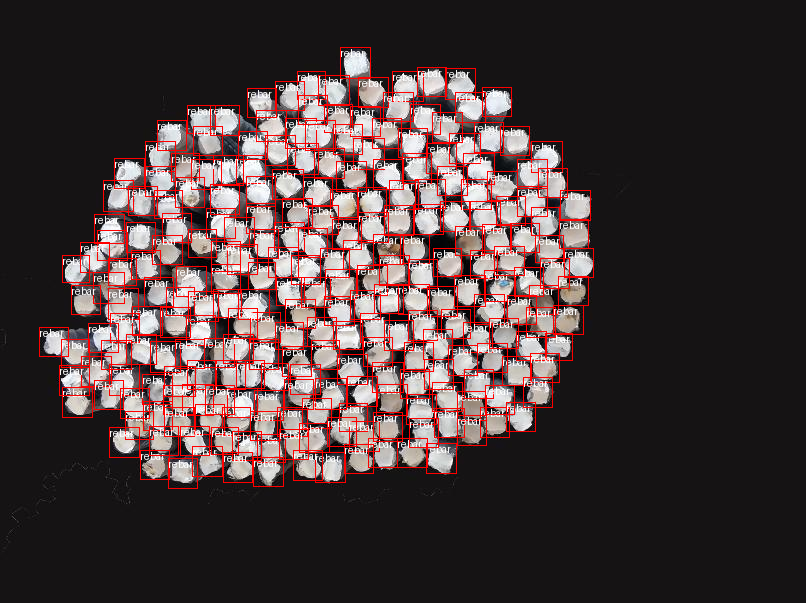

In [8]:
# Let's check one example

image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [9]:
# Create the data loaders
def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2, num_workers=0)
batch = next(iter(train_dataloader))

In [10]:
# Let's check the batch
print(batch.keys())
pixel_values, target = train_dataset[0]
print(pixel_values.shape)
print(target)

dict_keys(['pixel_values', 'pixel_mask', 'labels'])
torch.Size([3, 800, 1066])
{'size': tensor([ 800, 1066]), 'image_id': tensor([4]), 'class_labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'boxes': tensor([[0.7034, 0.6616, 0.0306, 0.0396],
        [0.7034, 0.6

In [11]:
# We define our model based on DETR
class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay, num_queries, num_labels, pretrained_model="facebook/detr-resnet-50"):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained(pretrained_model, 
                                                             num_labels=num_labels,
                                                             num_queries=num_queries,
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [12]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, num_queries=500, num_labels=len(id2label), pretrained_model=pretrained_model)
# We need to have at least 500 queries as the model will predict 500 bounding boxes, the default being 100
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [13]:
# Check the model architecture
print(model)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

## Train the model

In [15]:
trainer = Trainer(max_steps=500, gradient_clip_val=0.1)
trainer.fit(model)
trainer.save_checkpoint("./model/detr.ckpt")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.6 M
-------------------------------------------------
41.4 M    Trainable params
222 K     Non-trainable params
41.6 M    Total params
166.417   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.


AttributeError: 'Trainer' object has no attribute 'save_model'

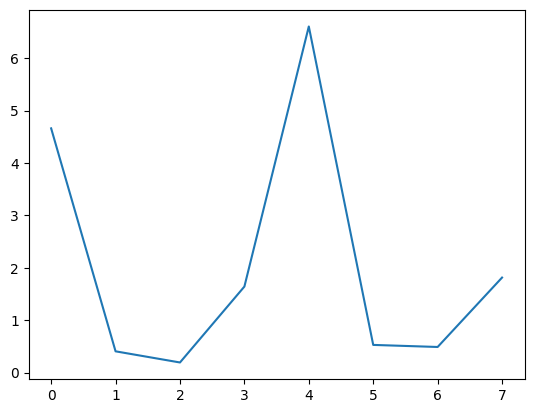

In [19]:
# Get statistics about the training
import matplotlib.pyplot as plt
metrics = trainer.callback_metrics
losses = [v for k,v in metrics.items() if "loss" in k]
plt.plot(losses)
plt.show()


In [20]:
# Get accuracy metrics on the validation set
trainer.validate(model)

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Validate metric               DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
validation_cardinality_error     202.86666870117188
      validation_loss            6.685040473937988
    validation_loss_bbox         0.5064445734024048
     validation_loss_ce          0.5142279863357544
    validation_loss_giou         1.8192957639694214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 6.685040473937988,
  'validation_loss_ce': 0.5142279863357544,
  'validation_loss_bbox': 0.5064445734024048,
  'validation_loss_giou': 1.8192957639694214,
  'validation_cardinality_error': 202.86666870117188}]

We can see that the model is not very accurate, but it's a good start. We can try to improve the model by changing the hyperparameters, or by using a different pre-trained model.

Here are the detailed explanations of the metrics:

 **validation_cardinality_error**: This metric measures the discrepancy between the number of predicted objects and the actual number of objects in the ground truth. A lower value means the model is better at predicting the correct number of objects in the image. In this case, the error is quite high, indicating that the model often predicts too many or too few objects.

 **validation_loss**: This is the total loss on the validation set. It's a combination of several other losses, including the classification loss (validation_loss_ce), bounding box loss (validation_loss_bbox), and the Generalized Intersection over Union loss (validation_loss_giou). The goal during training is to minimize this value.

**validation_loss_bbox**: This is the loss associated with predicting the bounding boxes of the objects. It measures how far off the predicted bounding boxes are from the actual bounding boxes in the ground truth. A lower value indicates better performance.

 **validation_loss_ce**: This is the cross-entropy loss for the classification task. It measures how well the model is doing at correctly identifying the classes of the objects. A lower value indicates better performance.

 **validation_loss_giou**: This is the Generalized Intersection over Union loss. It's a measure of how well the predicted bounding boxes and the ground truth bounding boxes overlap. A lower value indicates better performance.
 
In our case, since we only care about the count of rebar, we can use the validation_cardinality_error as our main metric.

## Evaluate the model on the test set

In [ ]:
# # Run the inference
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# 
# model.to(device)
# model.eval()

In [ ]:
# def count_rebar(outputs, threshold=0.7):
#   # keep only predictions with confidence >= threshold
#     probas = outputs.logits.softmax(-1)[0, :, :-1]
#     keep = probas.max(-1).values > threshold
# 
#   # return the count of rebar
#     return len(probas[keep])

In [ ]:
# # Get count from the CSV file
# res = pd.read_csv("RebarDSC/images/annotations/test.csv", header=None)
# res.columns = ["image_name", "bbox"]
# res["image_id"] = res["image_name"].apply(lambda x: int(x.split("_")[1]))
# # Get the count of rebar per image_id
# res = res.groupby("image_id").count().reset_index()
# res = res[["image_id", "bbox"]]
# res.columns = ["image_id", "count"]
# res

In [ ]:
# # Get the predictions
# pred_res = pd.DataFrame(columns=["image_id", "pred_count"])
# for it in iter(range(len(test_dataset))):
# # it = iter(range(len(test_dataset)))
#     pixel_values, target = test_dataset[it]
#     
#     pixel_values = pixel_values.unsqueeze(0).to(device)
#     # print(pixel_values.shape)
#     outputs = model(pixel_values=pixel_values, pixel_mask=None)
#     image_id = target['image_id'].item()
#     # image = test_dataset.coco.loadImgs(image_id)[0]
#     pred_count = count_rebar(outputs, threshold=0.8)
#     
#     pred_res.loc[len(pred_res)] = [image_id, pred_count]

In [ ]:
# # processor = DetrFeatureExtractor.from_pretrained(model)
# pixel_values, target = test_dataset[0]
# pixel_values = pixel_values.unsqueeze(0).to(device)
# outputs = model(pixel_values=pixel_values, pixel_mask=None)
# # results = processor.post_process_object_detection(outputs, target_sizes=2, threshold=0.9)[0]
# outputs
# # probas = outputs.logits.softmax(-1)[0, :, :-1]
# # probas
# # pixel_values
# # it

In [ ]:
# # Merge the predictions with the ground truth
# res = res.merge(pred_res, on="image_id")
# res

In [ ]:
# # Get the MSE (Mean Squared Error)
# print("MSE:", mean_squared_error(res["count"], res["pred_count"]))

In [ ]:
# # Compare the MSE to a naive model
# avg_count = res["count"].mean()
# print("MSE naive:", mean_squared_error(res["count"], [avg_count]*len(res)))